In [117]:

import pandas as pd
import numpy as np
import requests
import json
from typing import Dict, Any, Optional, List, Union
import seaborn as sns
import datetime
import time
import concurrent.futures

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans



In [118]:
Raw_Shots = pd.read_excel('/Users/gmarrero/Desktop/Personal_Projects/Golf_Distances_6.1.2025.xlsx')
Raw_Shots.head()
Raw_Shots.columns.values


array(['Club', 'Flat_Carry', 'Total_Distance', 'Ball_Speed',
       'Launch_Angle', 'Roll'], dtype=object)

In [119]:
Raw_Shots.groupby('Club').describe()

Flat_Carry                                                       \
              count        mean        std    min     25%    50%     75%   
Club                                                                       
3-wood          3.0  241.333333   3.511885  238.0  239.50  241.0  243.00   
4-hybrid        3.0  186.000000   7.211103  180.0  182.00  184.0  189.00   
4-wood          3.0  215.000000  16.643317  203.0  205.50  208.0  221.00   
5-hybrid        4.0  186.750000  13.817260  176.0  179.75  182.0  189.00   
52*             3.0   93.666667   6.429101   89.0   90.00   91.0   96.00   
56*             3.0   88.333333   2.516611   86.0   87.00   88.0   89.50   
6-iron          4.0  154.500000   3.696846  151.0  151.75  154.0  156.75   
60*             2.0   81.500000   0.707107   81.0   81.25   81.5   81.75   
7-iron          5.0  152.400000   3.974921  147.0  150.00  153.0  155.00   
8-iron          3.0  154.333333   7.234178  146.0  152.00  158.0  158.50   
9-iron          3.0  137.333333   6.110101  132.0  134.00  136.0  140.00   
Driver         10.0  244.200000  20.557778  214.0  230.25  248.0  257.75   
PW              8.0  120.000000  13.617216  104.0  108.75  116.0  135.25   

                Total_Distance              ... Launch_Angle        Roll  \
            max          count        mean  ...          75%   max count   
Club                                        ...                            
3-wood    245.0            3.0  266.000000  ...        14.50  15.0   3.0   
4-hybrid  194.0            3.0  193.000000  ...        21.50  22.0   3.0   
4-wood    234.0            3.0  231.000000  ...        17.00  18.0   3.0   
5-hybrid  207.0            4.0  193.500000  ...        21.00  21.0   4.0   
52*       101.0            3.0   93.000000  ...        49.50  52.0   3.0   
56*        91.0            3.0   88.333333  ...        45.50  48.0   3.0   
6-iron    159.0            4.0  163.250000  ...        21.75  24.0   4.0   
60*        82.0            2.0   81.000000  ...        49.00  50.0   2.0   
7-iron    157.0            5.0  158.600000  ...        22.00  24.0   5.0   
8-iron    159.0            3.0  158.666667  ...        26.00  26.0   3.0   
9-iron    144.0            3.0  139.666667  ...        32.00  35.0   3.0   
Driver    276.0           10.0  265.800000  ...        14.00  16.0  10.0   
PW        136.0            8.0  120.750000  ...        36.50  40.0   8.0   

                                                                
               mean        std   min    25%   50%    75%   max  
Club                                                            
3-wood    24.666667   7.571878  16.0  22.00  28.0  29.00  30.0  
4-hybrid   7.000000   1.732051   6.0   6.00   6.0   7.50   9.0  
4-wood    16.000000  10.816654   7.0  10.00  13.0  20.50  28.0  
5-hybrid   6.750000   2.362908   5.0   5.00   6.0   7.75  10.0  
52*       -0.666667   0.577350  -1.0  -1.00  -1.0  -0.50   0.0  
56*        0.000000   0.000000   0.0   0.00   0.0   0.00   0.0  
6-iron     8.750000   6.800735   2.0   5.00   7.5  11.25  18.0  
60*       -0.500000   0.707107  -1.0  -0.75  -0.5  -0.25   0.0  
7-iron     6.200000   2.280351   3.0   5.00   7.0   7.00   9.0  
8-iron     4.333333   0.577350   4.0   4.00   4.0   4.50   5.0  
9-iron     2.333333   0.577350   2.0   2.00   2.0   2.50   3.0  
Driver    21.600000  11.992590   8.0  10.75  19.0  31.25  41.0  
PW         0.750000   1.035098  -1.0   0.00   1.0   1.25   2.0  

[13 rows x 40 columns]

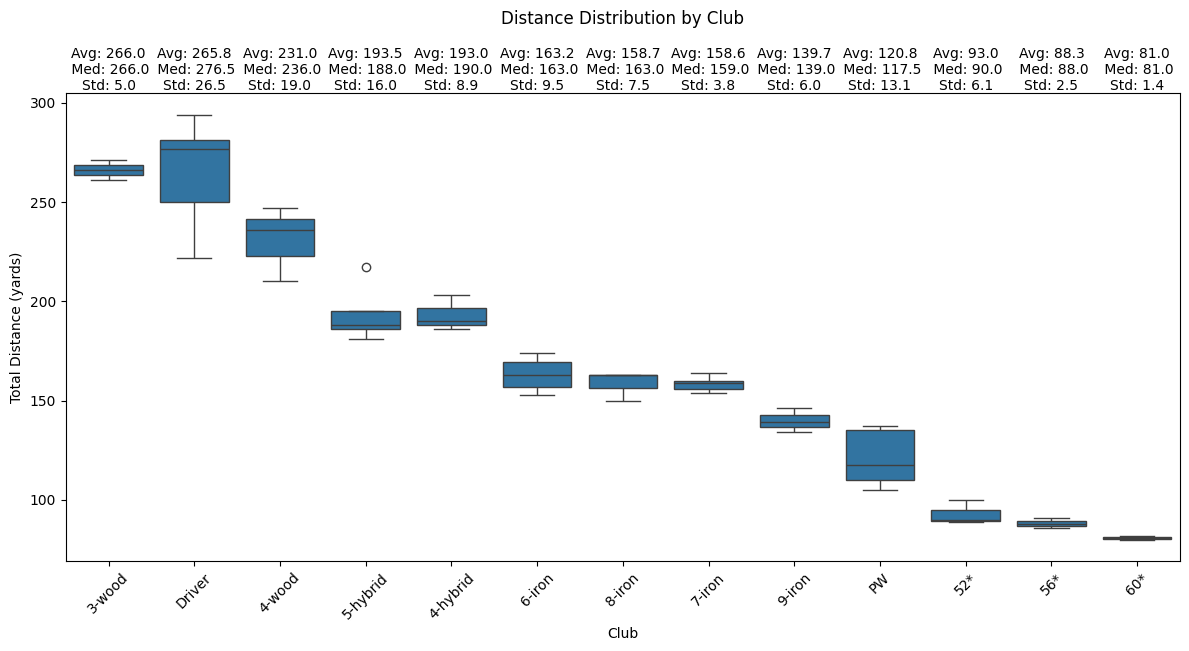

In [120]:
# Create box plots to show distance distribution by club, ordered by average total distance
club_order = Raw_Shots.groupby('Club')['Total_Distance'].mean().sort_values().index
plt.figure(figsize=(12,6))
sns.boxplot(x='Club', y='Total_Distance', data=Raw_Shots)
plt.xticks(rotation=45)
plt.xlabel('Club')
plt.ylabel('Total Distance (yards)')
plt.title('Distance Distribution by Club')
plt.tight_layout()

# Calculate averages and standard deviations for each club
club_stats = Raw_Shots.groupby('Club')['Total_Distance'].agg(['mean', 'std']).round(1)

# Calculate median values for each club
club_medians = Raw_Shots.groupby('Club')['Total_Distance'].median().round(1)

# Reverse the order of clubs to fix issue of overlapping labels
club_order = club_order[::-1]

plt.gca().clear()
sns.boxplot(x='Club', y='Total_Distance', data=Raw_Shots, order=club_order)
plt.xticks(rotation=45)
plt.xlabel('Club')
plt.ylabel('Total Distance (yards)')
plt.title('Distance Distribution by Club')
plt.tight_layout()

# Add text labels for mean, median and std dev with reversed order
for i, club in enumerate(club_order):
    mean = club_stats.loc[club, 'mean']
    std = club_stats.loc[club, 'std']
    median = club_medians[club]
    plt.text(i, plt.ylim()[1], f'Avg: {mean}\n Med: {median}\nStd: {std}', 
             ha='center', va='bottom')

# Adjust title position higher to accommodate extra text
plt.title('Distance Distribution by Club', pad=50)

plt.show()

# The cell above displays that I am not a great golfer (yet)
 
Although I do have some decent distances for a new golfer, we see some inconsidtancies in the distance achieveed by each club.

We see that my farthest hit shot during this range session was with a driver, but overall, my 3-wood actually has the farthest total distance on average. 

Considering the median distance my driver was farther then the median distance for my 3-wood, it appears that I just have too much variance in my driver distances, meaning that I am very inconsistant with this club.


/var/folders/qy/r76kf66n2bs673t7b5svdlf80000gp/T/ipykernel_88446/2989901396.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = plt.boxplot(distance_data, positions=positions1, patch_artist=True,
/var/folders/qy/r76kf66n2bs673t7b5svdlf80000gp/T/ipykernel_88446/2989901396.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = plt.boxplot(carry_data, positions=positions2, patch_artist=True,


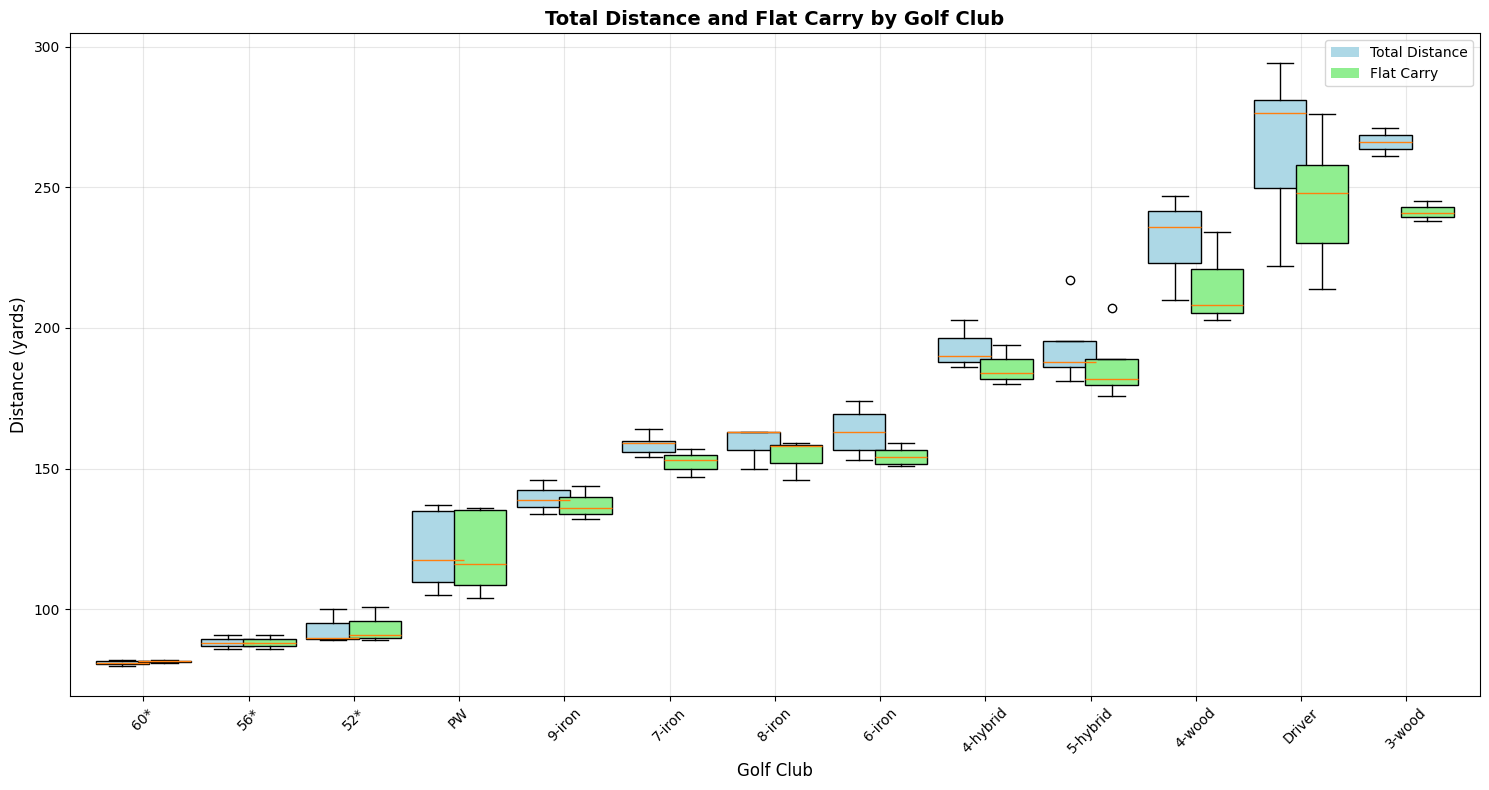

In [121]:
# Create a single figure and axis for both plots
plt.figure(figsize=(15, 8))

# Calculate averages and standard deviations for each club
club_stats = Raw_Shots.groupby('Club')['Total_Distance'].agg(['mean', 'std']).round(1)
# Calculate median values for each club
club_medians = Raw_Shots.groupby('Club')['Total_Distance'].median().round(1)
# Reverse the order of clubs to fix issue of overlapping labels
club_order = club_order[::-1]


# Create boxplots for both Total Distance and Flat Carry
distance_data = [Raw_Shots[Raw_Shots['Club'] == club]['Total_Distance'].values for club in club_order]
carry_data = [Raw_Shots[Raw_Shots['Club'] == club]['Flat_Carry'].values for club in club_order]

# Create positions for the boxes
positions1 = [i - 0.2 for i in range(len(club_order))]
positions2 = [i + 0.2 for i in range(len(club_order))]

# Create boxplots
bp1 = plt.boxplot(distance_data, positions=positions1, patch_artist=True, 
                  labels=[''] * len(club_order))  # Empty labels for now
bp2 = plt.boxplot(carry_data, positions=positions2, patch_artist=True,
                  labels=[''] * len(club_order))

# Color the boxes
colors = ['lightblue', 'lightgreen']
for patch in bp1['boxes']:
    patch.set_facecolor(colors[0])
for patch in bp2['boxes']:
    patch.set_facecolor(colors[1])

# Customize the plot
plt.title('Total Distance and Flat Carry by Golf Club', fontsize=14, fontweight='bold')
plt.ylabel('Distance (yards)', fontsize=12)
plt.xlabel('Golf Club', fontsize=12)
plt.xticks(range(len(club_order)), club_order, rotation=45)
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [Patch(facecolor=colors[0], label='Total Distance'),
                  Patch(facecolor=colors[1], label='Flat Carry')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# This plot compares Total Distance & Flat Carry. 

We see that my wedges perform as expexted, with them landing at a steep angle, allowing the vall to have very little to negative distance gained after the ball strikes the ground. This shows good landing angle, and also potentially backspin.

We also see the largest gap in Total Distance & Flay Carry with the 4-wood, 3-wood, & driver. This implies that the low launch angle and ball speed with these clubs is correct with what is expected. 

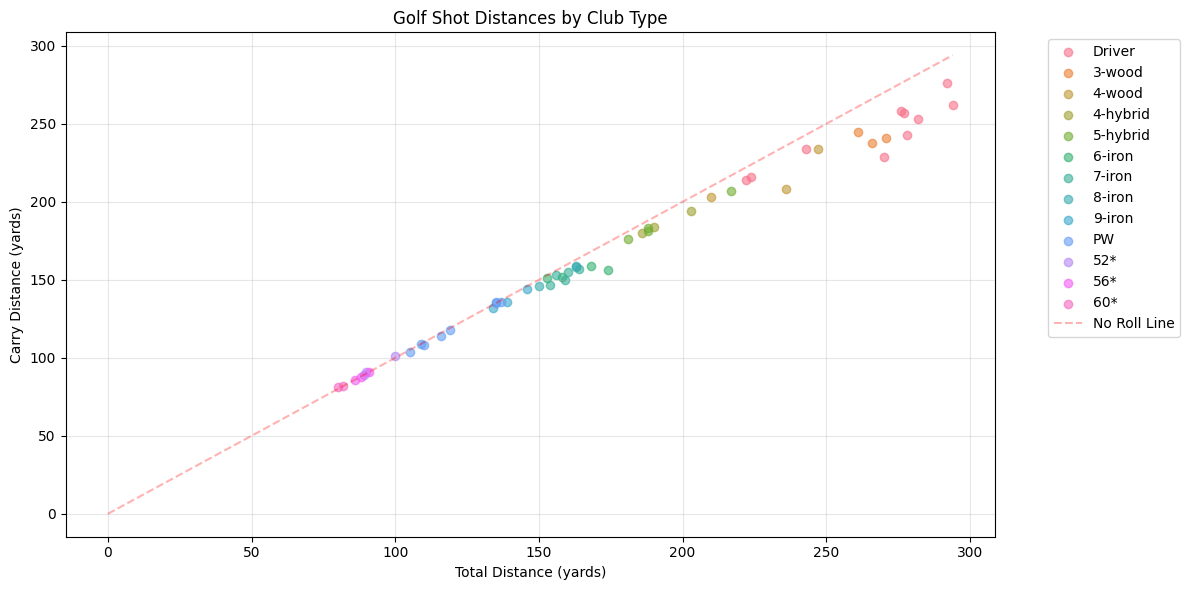

In [122]:
# Create scatter plot with different colors for each club
plt.figure(figsize=(12,6))

# Get unique clubs and create a color for each
clubs = Raw_Shots['Club'].unique()
colors = sns.color_palette("husl", len(clubs))

# Plot each club's data points with a different color
for club, color in zip(clubs, colors):
    club_data = Raw_Shots[Raw_Shots['Club'] == club]
    plt.scatter(club_data['Total_Distance'], club_data['Flat_Carry'], 
                label=club, color=color, alpha=0.6)

plt.xlabel('Total Distance (yards)')
plt.ylabel('Carry Distance (yards)')
plt.title('Golf Shot Distances by Club Type')

# Add the no-roll reference line
plt.plot([0, max_dist], [0, max_dist], 'r--', alpha=0.3, label='No Roll Line')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# This plot confirms our assumptions from the previous plot, where we see the Total Distance seperates from Flat Carry more with the clubs associated with farther total distance & lower lofts. 

<Figure size 1200x600 with 0 Axes>

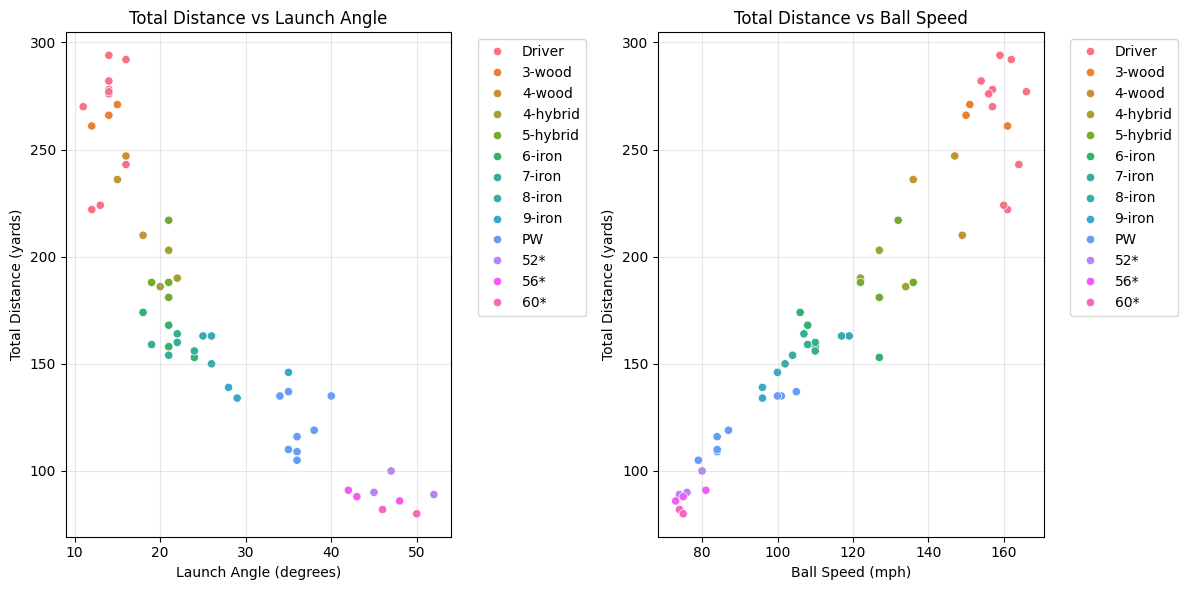

In [123]:
# Create correlation plot for Total Distance vs Launch Angle and Ball Speed
plt.figure(figsize=(12,6))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot Total Distance vs Launch Angle
sns.scatterplot(data=Raw_Shots, x='Launch_Angle', y='Total_Distance', hue='Club', ax=ax1)
ax1.set_xlabel('Launch Angle (degrees)')
ax1.set_ylabel('Total Distance (yards)')
ax1.set_title('Total Distance vs Launch Angle')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Total Distance vs Ball Speed
sns.scatterplot(data=Raw_Shots, x='Ball_Speed', y='Total_Distance', hue='Club', ax=ax2)
ax2.set_xlabel('Ball Speed (mph)')
ax2.set_ylabel('Total Distance (yards)')
ax2.set_title('Total Distance vs Ball Speed')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# These plots show Total Distance vs. Launch Angle & Total Distance vs. Ball Speed

As expected, we see that lower launch angles and higher ball speeds correalted to farther total distances.

<Figure size 1200x600 with 0 Axes>

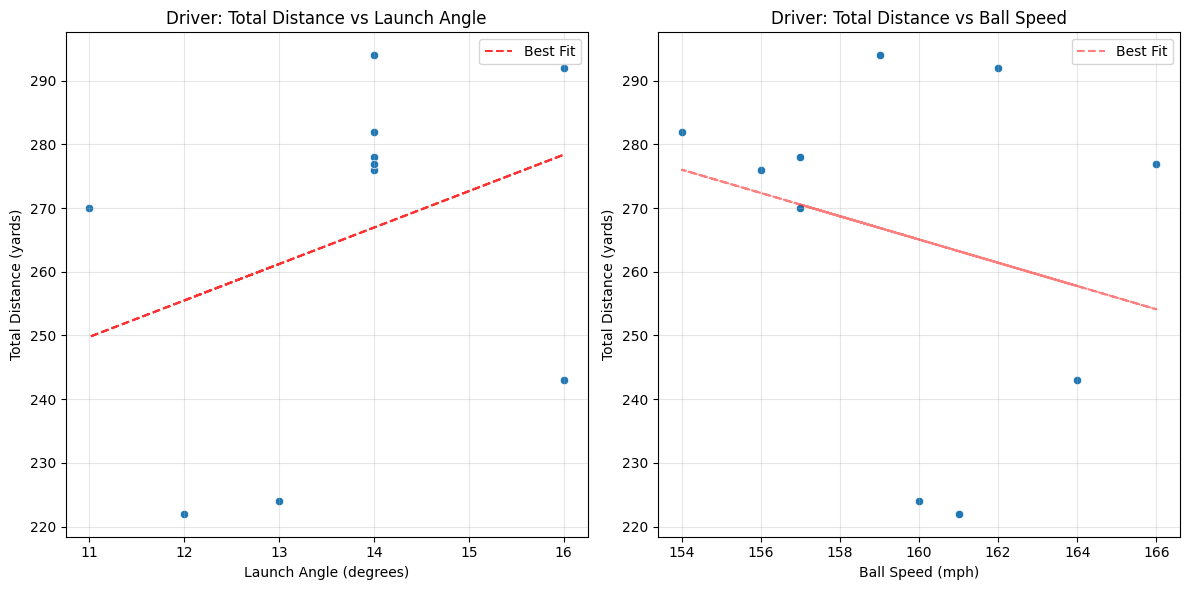

In [124]:
## Correlation plot for Driver shots

# Filter for Driver shots only
driver_shots = Raw_Shots[Raw_Shots['Club'] == 'Driver']

# Create correlation plot for Total Distance vs Launch Angle and Ball Speed
plt.figure(figsize=(12,6))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot Total Distance vs Launch Angle for Driver
sns.scatterplot(data=driver_shots, x='Launch_Angle', y='Total_Distance', ax=ax1)
ax1.set_xlabel('Launch Angle (degrees)')
ax1.set_ylabel('Total Distance (yards)')
ax1.set_title('Driver: Total Distance vs Launch Angle')
# Add best fit line using numpy's polyfit
z = np.polyfit(driver_shots['Launch_Angle'], driver_shots['Total_Distance'], 1)
p = np.poly1d(z)
ax1.plot(driver_shots['Launch_Angle'], p(driver_shots['Launch_Angle']), "r--", alpha=0.8, label='Best Fit')
ax1.legend()

ax1.grid(True, alpha=0.3)

# Plot Total Distance vs Ball Speed for Driver
sns.scatterplot(data=driver_shots, x='Ball_Speed', y='Total_Distance', ax=ax2)
ax2.set_xlabel('Ball Speed (mph)')
ax2.set_ylabel('Total Distance (yards)')
ax2.set_title('Driver: Total Distance vs Ball Speed')
# Add best fit line using numpy's polyfit
z = np.polyfit(driver_shots['Ball_Speed'], driver_shots['Total_Distance'], 1)
p = np.poly1d(z)
ax2.plot(driver_shots['Ball_Speed'], p(driver_shots['Ball_Speed']), "r--", alpha=0.5, label='Best Fit')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# These plots show specifically data from Driver shots.

# These plots show the he Total Distance vs. Launch Angle & Total Distance vs. Ball Speed

We notice that in shots with my driver, a higher launch angle correlates with father total distance. The average PGA tour driver launch angle is 10.9, which is significantly lower than my typical launch angle. Optimal launch angle for distance is 12-16 degrees, which is around my range.  I know that I have an issue with having too much launch angle on my driver and tend to hit up on the ball. 

We notice that there's a negative correlation between ball speed and total distance. This is interesting because you would obviously expect a higher ball speed to be associated with farther total distance. This should be further investigated, but I currently believe that the balls with a higher ball speed would be hit poorly, due to swinging too hard. These balls may either be offline, or be hit with a poor launch angle or ball spin, which then reduces total distance. 



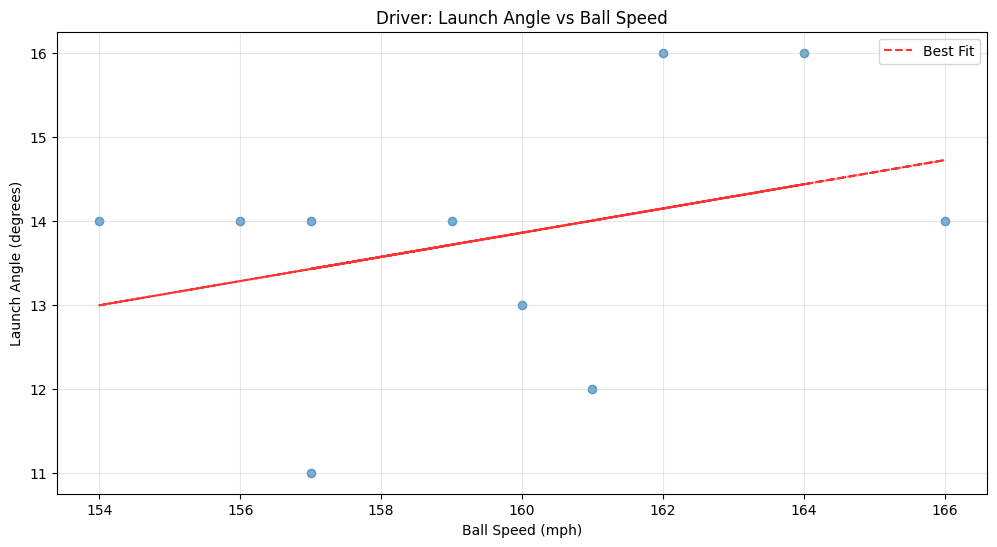

In [139]:
## Correlation plot for Driver shots - Launch Angle vs. Ball Speed

# Filter for Driver shots only
driver_shots = Raw_Shots[Raw_Shots['Club'] == 'Driver']

# Create scatter plot for Launch Angle vs Ball Speed
plt.figure(figsize=(12,6))

plt.scatter(driver_shots['Ball_Speed'], driver_shots['Launch_Angle'], alpha=0.6)
plt.xlabel('Ball Speed (mph)')
plt.ylabel('Launch Angle (degrees)')
plt.title('Driver: Launch Angle vs Ball Speed')

# Add best fit line
z = np.polyfit(driver_shots['Ball_Speed'], driver_shots['Launch_Angle'], 1)
p = np.poly1d(z)
plt.plot(driver_shots['Ball_Speed'], p(driver_shots['Ball_Speed']), "r--", alpha=0.8, label='Best Fit')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()


# Driver: Launch Angle vs. Ball Speed

We see that there is a positive correlation between Launch Angle and Ball Speed, which supports my previous theory that the balls hit the hardest, have a higher launch angle. We have limited datapoints here, but I believe that there is some effect of harder hit balls mangaging to be hit poorly. 

Text(0.5, 1.0, 'Driver: Launch Angle vs Ball Speed (Colored by Distance Percentile)')

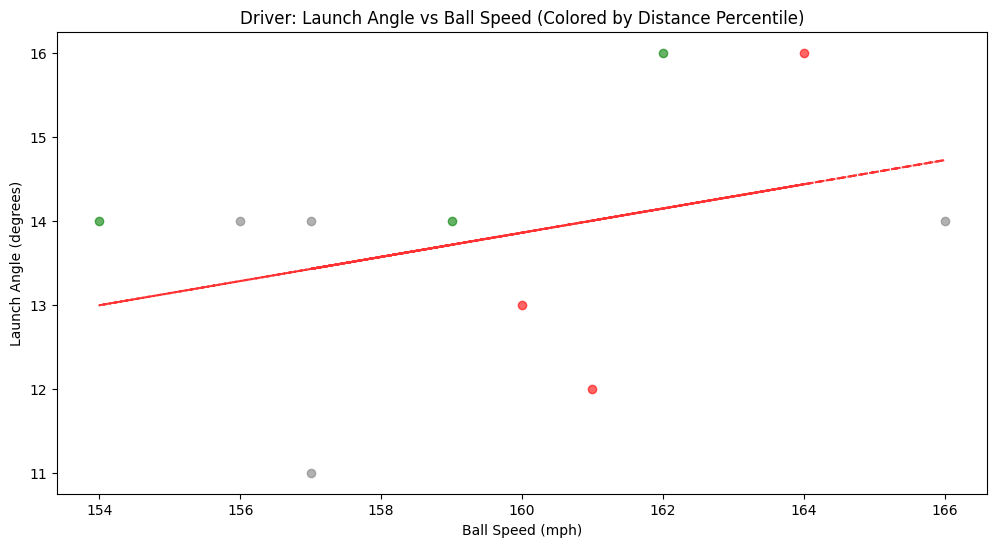

In [146]:
# Updated Launch Angle vs. Ball Speed Plot with Color for Total Distance

# Calculate mean total distance for driver shots
mean_total_distance = driver_shots['Total_Distance'].mean()

# Calculate percentile thresholds
lower_threshold = driver_shots['Total_Distance'].quantile(0.33)
upper_threshold = driver_shots['Total_Distance'].quantile(0.67)

# Create scatter plot with points colored by total distance percentiles
plt.figure(figsize=(12,6))

# Plot bottom 33% in red
bottom_third = driver_shots[driver_shots['Total_Distance'] <= lower_threshold]
plt.scatter(bottom_third['Ball_Speed'], bottom_third['Launch_Angle'], 
           color='red', alpha=0.6, label='Bottom 33%')

# Plot middle 33% in grey
middle_third = driver_shots[(driver_shots['Total_Distance'] > lower_threshold) & 
                          (driver_shots['Total_Distance'] <= upper_threshold)]
plt.scatter(middle_third['Ball_Speed'], middle_third['Launch_Angle'],
           color='grey', alpha=0.6, label='Middle 33%')

# Plot top 33% in green
top_third = driver_shots[driver_shots['Total_Distance'] > upper_threshold]
plt.scatter(top_third['Ball_Speed'], top_third['Launch_Angle'],
           color='green', alpha=0.6, label='Top 33%')

# Add best fit line
z = np.polyfit(driver_shots['Ball_Speed'], driver_shots['Launch_Angle'], 1)
p = np.poly1d(z)
plt.plot(driver_shots['Ball_Speed'], p(driver_shots['Ball_Speed']), "r--", alpha=0.8, label='Best Fit')


plt.xlabel('Ball Speed (mph)')
plt.ylabel('Launch Angle (degrees)')
plt.title('Driver: Launch Angle vs Ball Speed (Colored by Distance Percentile)')


# The plot above is updated with color coordination for total distance of the shots.

Top 33% in Total Distance: Green
Middle 33% in Total Distance: Green
Bottom 33% in Total Distance: Green

We see that the farthest shots have a higher launch angle, but are not necessarily the hardest hit shots. We also see thta the shots that went the shortest, happened to have a pretty high ball speed. This allows us to confirm that the hardest hit balls are probably hit poorly, either in launch angle, backspin, or angle. 

Model Performance Metrics:
Mean Squared Error: 110.51
R-squared Score: -0.04

Feature Coefficients:
Ball_Speed: 0.18
Launch_Angle: -2.26
Intercept: 186.48


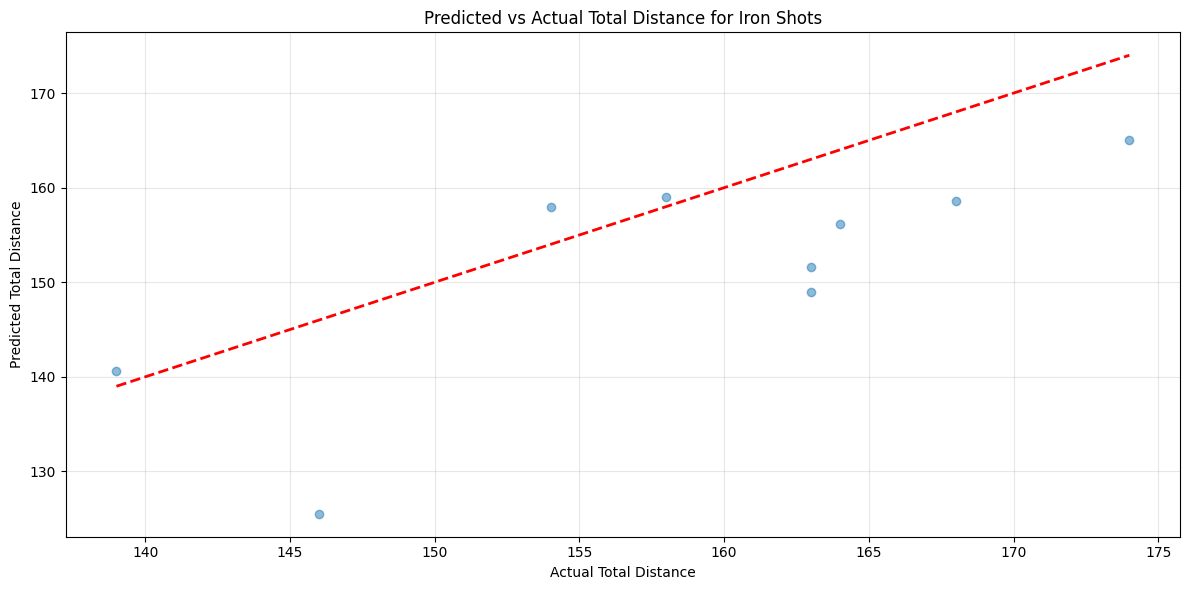


Model Interpretation:
The scatter plot shows the relationship between actual and predicted total distances for iron shots.
With an R-squared value of -0.04, the model explains -3.9% of the variance in the data.
This indicates a weak predictive relationship between ball speed/launch angle and total distance.

The diagonal red line represents perfect predictions.
Points close to this line indicate accurate predictions, while scattered points show prediction errors.

On average, predictions are off by 8.7 yards.

Feature Importance:
Ball_Speed: 7.4%
Launch_Angle: 92.6%


In [147]:
## Predicting Total Distance from Ball Speed and Launch Angle for irons using Linear Regression

# Filter for clubs with 'iron' in the name
iron_shots = Raw_Shots[Raw_Shots['Club'].str.contains('iron', case=False)]

# Prepare features (X) and target (y)
X = iron_shots[['Ball_Speed', 'Launch_Angle']]
y = iron_shots['Total_Distance']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate and print model performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Print feature coefficients
feature_names = ['Ball_Speed', 'Launch_Angle']
print("\nFeature Coefficients:")
for feature, coef in zip(feature_names, model.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Distance')
plt.ylabel('Predicted Total Distance')
plt.title('Predicted vs Actual Total Distance for Iron Shots')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpret the scatter plot and model performance
print("\nModel Interpretation:")
print("The scatter plot shows the relationship between actual and predicted total distances for iron shots.")
print(f"With an R-squared value of {r2:.2f}, the model explains {r2*100:.1f}% of the variance in the data.")

if r2 > 0.7:
    print("This indicates a strong predictive relationship between ball speed/launch angle and total distance.")
elif r2 > 0.5:
    print("This indicates a moderate predictive relationship between ball speed/launch angle and total distance.")
else:
    print("This indicates a weak predictive relationship between ball speed/launch angle and total distance.")

print("\nThe diagonal red line represents perfect predictions.")
print("Points close to this line indicate accurate predictions, while scattered points show prediction errors.")

# Calculate average error
avg_error = abs(y_test - y_pred).mean()
print(f"\nOn average, predictions are off by {avg_error:.1f} yards.")

# Analyze feature importance
abs_coefficients = abs(model.coef_)
importance = abs_coefficients / sum(abs_coefficients) * 100
print("\nFeature Importance:")
for feature, imp in zip(feature_names, importance):
    print(f"{feature}: {imp:.1f}%")



# Simple Linear Regression model to predict the distance of iron shots using Ball Speed & Launch Angle

We ultimately see that launch angle possessses significantly more predictive power when trying to forecast total distance, which makes sense given that clubs are designed to provide different launch angles, while ball speed can only fluctuate so much between different club angles. 


Feature Coefficients:
Ball_Speed: -1.25
Launch_Angle: 18.81
Intercept: 207.32


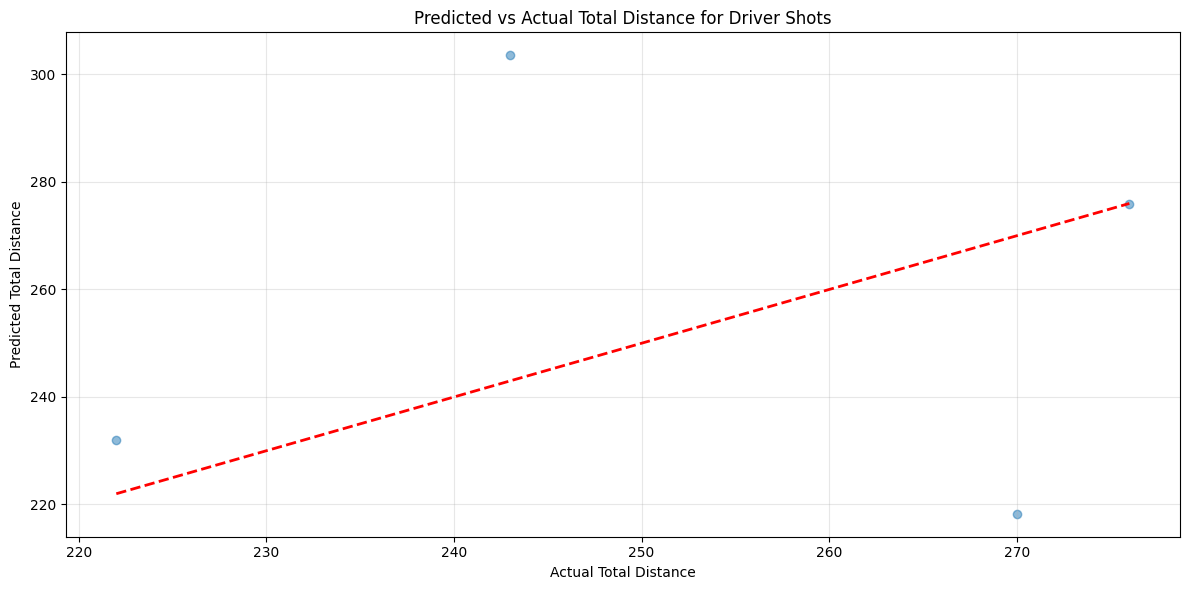


Model Interpretation:
The scatter plot shows the relationship between actual and predicted total distances for driver shots.
With an R-squared value of -2.43, the model explains -243.2% of the variance in the data.
This indicates a weak predictive relationship between ball speed/launch angle and total distance.

The diagonal red line represents perfect predictions.
Points close to this line indicate accurate predictions, while scattered points show prediction errors.

On average, predictions are off by 30.6 yards.

Feature Importance:
Ball_Speed: 6.2%
Launch_Angle: 93.8%


In [152]:
## Predicting Total Distance from Ball Speed and Launch Angle for Driver

# Filter data for Driver shots
driver_data = Raw_Shots[Raw_Shots['Club'] == 'Driver']

# Prepare features and target
X_driver = driver_data[['Ball_Speed', 'Launch_Angle']]
y_driver = driver_data['Total_Distance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_driver, y_driver, test_size=0.4, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print feature coefficients
feature_names = ['Ball_Speed', 'Launch_Angle']
print("\nFeature Coefficients:")
for feature, coef in zip(feature_names, model.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Distance')
plt.ylabel('Predicted Total Distance')
plt.title('Predicted vs Actual Total Distance for Driver Shots')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpret the scatter plot and model performance
print("\nModel Interpretation:")
print("The scatter plot shows the relationship between actual and predicted total distances for driver shots.")
print(f"With an R-squared value of {r2:.2f}, the model explains {r2*100:.1f}% of the variance in the data.")

if r2 > 0.7:
    print("This indicates a strong predictive relationship between ball speed/launch angle and total distance.")
elif r2 > 0.5:
    print("This indicates a moderate predictive relationship between ball speed/launch angle and total distance.")
else:
    print("This indicates a weak predictive relationship between ball speed/launch angle and total distance.")

print("\nThe diagonal red line represents perfect predictions.")
print("Points close to this line indicate accurate predictions, while scattered points show prediction errors.")

# Calculate average error
avg_error = abs(y_test - y_pred).mean()
print(f"\nOn average, predictions are off by {avg_error:.1f} yards.")

# Analyze feature importance
abs_coefficients = abs(model.coef_)
importance = abs_coefficients / sum(abs_coefficients) * 100
print("\nFeature Importance:")
for feature, imp in zip(feature_names, importance):
    print(f"{feature}: {imp:.1f}%")


# Simple Linear Regression model to predict the distance of driver shots using Ball Speed & Launch Angle

In this basic model, we see that launch angle is our best predictive variable, while our model could certainly use more datapoints & possible outlier rejection. 